# LSTM - Time Serise Dataset

- 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
- https://data.kma.go.kr/cmmn/main.do
- 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> - - 검색 -> CSV 다운로드
- Seoul_Temp.csv

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

- Packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# I. Colab File Upload

> ## 1) 'Seoul_Temp.csv' 파일을 Colab에 업로드 후 진행

In [ ]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)
temp.info()

In [ ]:
temp.head()

# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

- 일일 평균온도 변화에 일정한 패턴 확인

In [ ]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

  - tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

- Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
- Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [ ]:
train = temp_data[0:2557]
test = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

  - X : 학습 평균온도 데이터
  - y : 정답 평균온도 데이터
  - 일정 기간의 X로 y를 예측하도록 학습

In [ ]:
def create_dataset(time_data, look_back = 1):
  data_X, data_y = [], []

  for i in range(len(time_data) - look_back):
      data_X.append(time_data[i:(i + look_back), 0])
      data_y.append(time_data[i + look_back, 0])

  return np.array(data_X), np.array(data_y) 

> ## 2) loop_back 기간 설정 후 학습데이터 생성

- 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [ ]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X.shape, test_X.shape, train_y.shape, test_y.shape

> ## 3) Tensor Reshape

In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, test_X.shape, train_y.shape, test_y.shape

# IV. LSTM Modeling

> ## 1) Model Define

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential(name = 'LSTM')
model.add(LSTM(128,
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [12]:
model.compile(loss = 'mse',
              optimizer = 'rmsprop',
              metrics = ['mae'])

> ## Model Fit
  
  - 약 7분

In [13]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 17s 26ms/step - loss: 0.0212 - mae: 0.1094 - val_loss: 0.0151 - val_mae: 0.0976
Epoch 2/200
149/149 [==============================] - 3s 18ms/step - loss: 0.0141 - mae: 0.0915 - val_loss: 0.0152 - val_mae: 0.0992
Epoch 3/200
149/149 [==============================] - 3s 22ms/step - loss: 0.0125 - mae: 0.0856 - val_loss: 0.0108 - val_mae: 0.0810
Epoch 4/200
149/149 [==============================] - 2s 16ms/step - loss: 0.0113 - mae: 0.0810 - val_loss: 0.0096 - val_mae: 0.0739
Epoch 5/200
149/149 [==============================] - 2s 16ms/step - loss: 0.0105 - mae: 0.0775 - val_loss: 0.0092 - val_mae: 0.0730
Epoch 6/200
149/149 [==============================] - 2s 14ms/step - loss: 0.0099 - mae: 0.0757 - val_loss: 0.0103 - val_mae: 0.0796
Epoch 7/200
149/149 [==============================] - 2s 13ms/step - loss: 0.0095 - mae: 0.0737 - val_loss: 0.0089 - val_mae: 0.0739
Epoch 8/200
149/149 [==============================] - 3s 22m

> ## 4) 학습결과 시각화

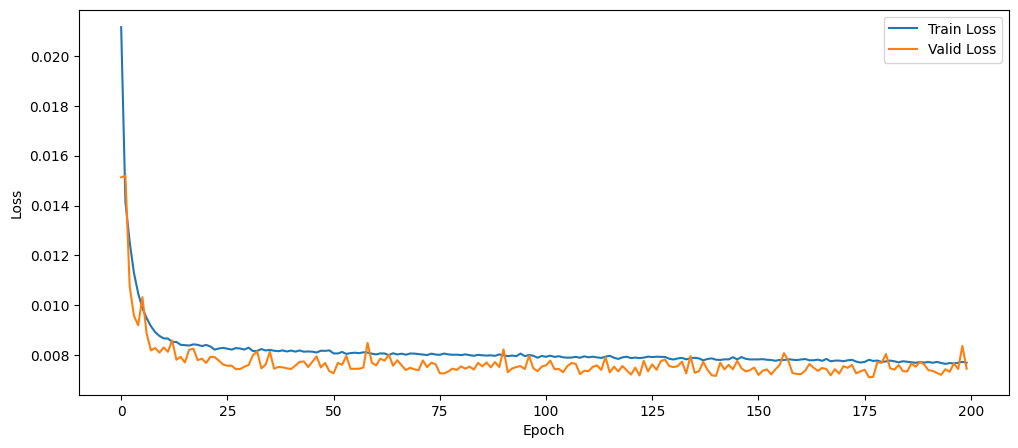

In [15]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

> ## 5) Model Evaludate

In [16]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score : ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score : ', testScore)

Train Score :  [0.007657228969037533, 0.06484182924032211]
Test Score :  [0.007451345212757587, 0.06439244002103806]


# V. Model Predict

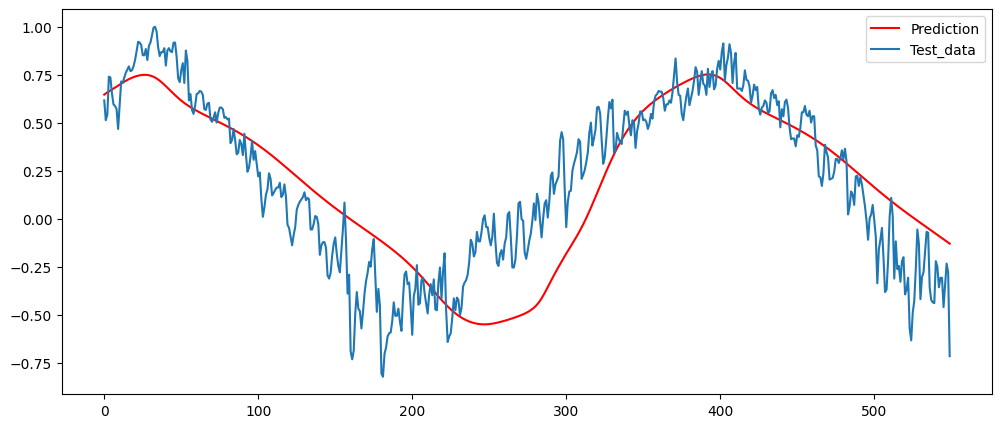

In [17]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1, verbose = 0)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
  
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_data')
plt.legend()
plt.show()